In [33]:
import numpy as np
import pandas as pd
import spacy as sp

import glob
import os,sys,inspect
import argparse
import re
import ast

import matplotlib.pyplot as plt
from xml.etree import ElementTree

CURRENTDIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,'%s/SPPAS'%CURRENTDIR)
sys.path.insert(3,CURRENTDIR)
import SPPAS.sppas.src.anndata.aio.readwrite as spp

from textblob import TextBlob
from collections import Counter
import seaborn as sns

# Tag with Spacy

In [4]:
def extract_tier(file_name, tier_name="Transcription"):
    """Read file and extract tier for analysis (either left or right tier)
    
    Input:
    -----------
    file_name: str
        name of file to be analysed
    tier_name: str 
        tiers to look for before using IPUs
    
    Output:
    -----------
    tier: sppasTier
    """
    parser = spp.sppasRW(file_name)
    trs = parser.read()
    if tier_name in [tier.get_name() for tier in trs]: # needs checking since missing tier_name still return sth
        tier = parser.read().find(tier_name)
    else:
        tier = parser.read().find("IPUs")
    return tier

In [5]:
def get_interval(sppasObject):
    """ Return the transcriped text and the IPU start/stop points for a given annotation.
    
    Input:
    -----------
    sppasObject: sppasAnnotation
    
    Output:
    -----------
    label: str
    [start, stop]: array of floats
    [start_radius, stop_radius]: array of floats
    """
    # speech
    label = sppasObject.serialize_labels() # labels => returns speech only
    # location
    location = sppasObject.get_location()[0][0]
    start = location.get_begin().get_midpoint()
    stop = location.get_end().get_midpoint()
    # the radius represents the uncertainty of the localization
    start_radius = location.get_begin().get_radius()
    stop_radius = location.get_end().get_radius()

    return label, [start, stop], [start_radius, stop_radius]

def get_ipu(tier, minimum_length = 0.5):
    """List all IPUs for one tier and returns transcribed text (if not empty) and start/stop points.
    
    Input:
    -----------
    tier: sppasTier
    minimum_length: float
        duration of short answers to remove
    
    Output:
    -----------
    p: pd.DataFrame
    """
    d = []

    for sppasOb in tier:
        label, [start, stop], [start_r, stop_r] = get_interval(sppasOb)
        if label in ["#", "", " ", "***", "*"]:
            continue
        else:
            if (stop - start) >= minimum_length:
                d.append({'label': label, 'start':start, 'stop':stop, 'duration':stop - start})
    return pd.DataFrame(d)

Maintenant la partie tags:

In [6]:
def tag_one(sentence, nlp=sp.load('fr_core_news_sm')):
    """Extract POS tags for one sentence or one - aligning with MarsaTag (simplified output: no Cc nor Cs)
    
    Input:
    --------
    sentence: str
        sentence extracted from Textgrid
    nlp: spacy language model
        default: 'fr_core_news_sm'
    
    Output:
    --------
    p_spacy: pd.DataFrame
        shape [form, pos]
    """
    p_spacy = []
    d_marsa = {'ADJ': 'ADJ', 'ADP':'PREP', 'ADV': 'ADV', 'AUX': 'VERB', 'CONJ':'CONJ', 'CCONJ':'CONJ', \
              'DET':'DET', 'INTJ': 'INTJ', 'NOUN':'NOUN', 'NUM':'DET', 'PART':'ADV', 'PRON':'PRON', \
              'PROPN':'NOUN', 'PUNCT':'PUNCT', 'SCONJ':'CONJ', 'SYM':'X', 'VERB':'VERB', 'X':'X', 'SPACE':'SPACE'}
    for d in nlp(sentence):
        try:
            p_spacy.append({'form':d, 'original_pos':d.pos_, 'pos': d_marsa[d.pos_]})
        except:
            print(d, d.pos_)
    return pd.DataFrame(p_spacy)

# Tag with MarsaTag

In [7]:
def one_marsa(input_path, locutor = 'Transcription', output_path='log.xml'):
    """Execute one parsing of MarsaTag with CLI command, saves as XML
    
    MarsaTag arguments:
        * -r: format (Textgrid)
        * -pt: tier
        * --oral
        * -P: POS
    
    Input:
    ---------
    input_path: str
        local path, Jupyter cannot access files outside of root
    locutor: str
        tiers to look for before using IPUs
    output_path: str
        local path, XML file, default: log.xml
    """
    s = "./MarsaTag/MarsaTag-UI.sh --cli -r praat-textgrid -pt {} -P --oral ".format(locutor)
    #os.system(s + input_path + ' > ' + output_path)
    print(os.popen(s + input_path + ' > ' + output_path).read())

In [8]:
def read_marsa(file_path):
    """Read XML file and return list of tokens
    
    Known structure:
    ---------
    <?xml version='1.0' encoding='UTF-8'?>
    <?xml-stylesheet type="text/xsl" href="mars.xsl"?>
    <document format="MARS_1.0">
        <sample>
        
        ... List of tokens:
        <token form="..." regex_type="..." features="...">
            ... One solution and several propositions:
            <solution msc=".." type="..."/>
            <proposition msc=".." frequency=".."/>
        </token>
        
        </sample>
    </document>
    
    Input:
    ---------
    file_path: str
        local path, Jupyter cannot access files outside of root, XML file
    
    Output:
    ---------
    tree: xml.etree.ElementTree.Element
    """
    tree = ElementTree.parse(file_path)
    # getroot() gets document, getchildren()[0] gets sample ==> access tokens
    return tree.getroot().getchildren()[0] 

In [9]:
def marsatag_to_sentence(document, remove_punct=False, remove_ipu=True):
    sentence = ''
    for child in document:
        if child.tag == 'token':
            sentence += '' if (len(sentence) == 0 or child.attrib['form'] in [',', '.', "'"]) else ' '
            sentence += child.attrib['form']
    return sentence

In [10]:
def marsatag_to_pandas(document, with_inserted=True):
    """Select words & tags from xml 
    
    Input:
    -------
    document: xml.etree.ElementTree.Element
    with_inserted: bool
        whether to remove punctuation inserted by MarsaTag
    
    Output:
    -------
    sentence: dataframe
        shape ['form', 'pos', 'lemma', 'inserted']
    """
    sentence = []
    d = {'A': 'ADJ', 'D':'DET', 'R': 'ADV', 'V': 'VERB', 'C': 'CONJ', 'N': 'NOUN', 
         'S':'PREP', 'W':'PUNCT', 'I':'INTJ', 'P':'PRON', 'U':'X'}
    for child in document:
        if child.tag == 'token':
            # first child is solution, if exists
            try:
                sentence.append({'form': child.attrib['form'], \
                             'pos': d[child.attrib['features'][0]], \
                             'lemma': None if 'lemma' not in child.attrib.keys() else child.attrib['lemma'], \
                             'inserted': (child.attrib['regex_type'] == 'inserted') \
                            })
            except: # erreur de type """<token form="-" regex_type="Ponct_Wm1">"""
                sentence.append({'form': child.attrib['form'], \
                             'pos': 'PUNCT', \
                             'lemma': None if 'lemma' not in child.attrib.keys() else child.attrib['lemma'], \
                             'inserted': (child.attrib['regex_type'] == 'inserted') \
                            })
    if with_inserted:
        return pd.DataFrame(sentence)
    else:
        p = pd.DataFrame(sentence)
        return p[~p.inserted]

# Useful functions

In [11]:
# https://regex101.com
# https://regexr.com

patterns_dic = {' [sS]pider(.+?){0,1}man ': ' Spiderman ', 
                ' [bB]at(.+?){0,1}man ': ' Batman ', ' \[(.+?)\] ':' ', ' (\w+-|-\w+) ':' ', "' ":"'"}

In [12]:
def clean_text(text, patterns_dic):
    # remove '$'
    t = text.replace('$', '')
    # replace patterns
    for k,v in patterns_dic.items():
        t = re.sub(k,v,t)
    return t

In [13]:
def extract_text(df, replace_in_text=True, join_with=' '):
    if replace_in_text:
        return clean_text(' '.join(df.form.values), patterns_dic)
    else:
        return ' '.join(df.form.values)

In [14]:
def filename_analyser(fn):
    """
    example: S19_Sess3_CONV2_002-conversant.TextGrid
    """
    [sub, block, conv, nb] = fn.replace('.TextGrid', '').split('_')
    [nb, tier] = nb.split('-')
    return int(sub[1:]), int(block.replace('Sess', '')), int(conv.replace('CONV', '')), int(nb), tier

In [15]:
def create_conversation(file_conv, file_part, minimum_length=0., remove_laughter=True):
    """
    Doc for sequential groupby: https://stackoverflow.com/questions/53091343/pandas-groupby-sequential-values

    Input:
    ------------
    file_conv: str
        location of locutor 1
    file_part: str
        location of locutor 2
    minimum_length: float
        duration of short answers to remove - for Spacy analysis
    remove_laughter: bool
        whether to remove laughter (and by extension, ipus comprised of laugther only)
    
    Output:
    ------------
    p: pd.DataFrame
        dataframe of shape ['start_time', 'stop_time', 'tier', 'concatenated_text']
    """
    # file to data 
    p = []
    for f,n in zip([file_conv, file_part], ["conversant", "participant"]):
        tier_conv = extract_tier(f)
        data_conv = get_ipu(tier_conv, minimum_length)
        data_conv["tier"] = n
        p.append(data_conv.drop(np.where(data_conv.label == '@')[0])) # removing laughters - feedback => not removed
    p = pd.concat(p).sort_values(by='start').reset_index(drop=True)
    p.label = p.label.apply(lambda x: x.replace('@', ''))
    df = p.groupby((p.tier!=p.tier.shift()).cumsum()).agg(**{'concatenated_text':pd.NamedAgg(column='label', aggfunc= (lambda x: ' '.join(x))),
                                                            'start_time':pd.NamedAgg(column='start', aggfunc= min),
                                                            'stop_time': pd.NamedAgg(column='stop', aggfunc= max) }).reset_index(drop=True)
    add_tier = ('conversant', 'participant') if p.tier[0] == 'conversant' else ('participant', 'conversant')
    df['tier'] = [ add_tier[i%2] for i in range(df.shape[0])]
    return df

In [16]:
def extract_pv_text(df, tier='conversant'):
    """ Extracting, for each line of "tier", what comes before / after for the other locutor

    Input:
    --------
    df: pd.DataFrame
        output of create_conversation, shape ['start_time', 'stop_time', 'tier', 'concatenated_text']
        every line is a different locutor
    tier: str
        in 'conversant', 'participant'
    
    Output:
    --------
    pv_text: list 
        list of dict of shape ['before_oth', 'tier', 'after_oth'] containing concatenated dialog
    """
    oth = 'participant' if tier == 'conversant' else 'conversant'
    pv_text = []
    for i in list(df[df.tier == tier].index):
        pv_text.append({'before_oth': ' '.join(df[(df.tier == oth) & (df.index < i)][:i].concatenated_text), 
                        'tier': df.concatenated_text[i],
                        'after_oth': ' '.join(df[(df.tier == oth) & (df.index >= i)].concatenated_text)})
    return pv_text

In [17]:
remove_lemmas = {'aux':["avoir", "aller", "devoir", "pouvoir", "venir", "vouloir", "savoir", "faire", "falloir"], 
                    'etat':["être", "devenir", "paraître", "sembler", "ressembler", "rester", "apparaître", "tomber", "vivre"] }
# patterns à conserver: NOUN, ADJ, VERB - si lemma pas dans la liste

In [26]:
def extract_vocab_count(df, nlp = sp.load('fr_core_news_sm'), keep_POS = ['NOUN', 'ADJ', 'VERB'], exceptions = [y for x in remove_lemmas.values() for y in x]):
    """ Extracts vocabulary introduced by locutor, and counts occurences in posterior dialog by other participant

    Input:
    --------
    df: pd.DataFrame or list
        output of extract_pv_text, shape ['before_oth', 'tier', 'after_oth']
    nlp: Spacy.nlp
        language POS parser
    keep_POS: list
        list of strings, of POS tags to keep for content (lemmas)
    exceptions: list
        list of strings, lemmas of verbs not to count in content words
    
    Output:
    --------
    l: list
        list of lists (one list: 1 sentence - sublist: tuples ('word', 'nb_occurrences'))
    ignored_vocab: list
        list of vocab introducted by the other locutor
    """
    l = []
    tier_vocab = []
    ignored_vocab = []
    d_marsa = {'ADJ': 'ADJ', 'ADP':'PREP', 'ADV': 'ADV', 'AUX': 'VERB', 'CONJ':'CONJ', 'CCONJ':'CONJ', \
              'DET':'DET', 'INTJ': 'INTJ', 'NOUN':'NOUN', 'NUM':'DET', 'PART':'ADV', 'PRON':'PRON', \
              'PROPN':'NOUN', 'PUNCT':'PUNCT', 'SCONJ':'CONJ', 'SYM':'X', 'VERB':'VERB', 'X':'X', 'SPACE':'SPACE', '':'KEYERROR'}
    for d in df: # for each conversant sentence
        # 1. Apply POS tagging - nlp - on every sentence.
        pre = nlp(d['before_oth'])
        post = nlp(d['after_oth'])
        # 2. Add vocab matching keep_POS tags to curr_vocab / ignored_vocab (lemmas)
        ignored_vocab += [ x.lemma_ for x in pre if (d_marsa[x.pos_] in keep_POS) and (x.lemma_ not in exceptions) ]
        curr_vocab = [ x.lemma_ for x in nlp(d['tier']) if (d_marsa[x.pos_] in keep_POS) and (x.lemma_ not in exceptions) and (x.lemma_ not in set(ignored_vocab))]
        tier_vocab += curr_vocab # for analysis
        # 3. Count vocab in post speech
        l.append(Counter([x.lemma_ for x in post if x.lemma_ in curr_vocab]))

    return l, list(set(ignored_vocab)), list(set(tier_vocab))

In [ ]:
def compute_dist

In [56]:
def compute_scc_voc(prime_text, target_text, keep_POS = None, n=10, exceptions=[y for x in remove_lemmas.values() for y in x]):
    """Compute Spearman's correlation coefficient based on the Xu & Reiter paper.

    Some questions though:
    * comment tu choisis les mots ? est-ce que c'est les mots communs ou les mots les plus fréquents indépendamment ?
    * si c'est indépendamment, comment tu gères qu'un mot n'apparaisse pas chez l'autre ?
    * est-ce que tu prends n'importe quel mot ou n'importe quel mot de contenu ?
    ==> choosing only most frequent words _appearing in both texts_.

    Input:
    --------
    conversant_text: pd.DataFrame
        output of MarsaTag, shape ['form', 'pos', 'lemma', 'inserted']
    participant_text: pd.DataFrame
        output of MarsaTag, shape ['form', 'pos', 'lemma', 'inserted']
    keep_POS: list
        default None, most often ['NOUN', 'ADJ', 'VERB'], vocab to rank
    exceptions: list
        list of words not to take into account
    """
    scc = 0
    if keep_POS is not None:
        prime_text = prime_text[prime_text.pos.isin(keep_POS)]
        target_text = target_text[target_text.pos.isin(keep_POS)]
    # defaults: sort = True, ascending = False / transforming to DF to apply rank for computation
    most_frequent_words = list(pd.concat([prime_text, target_text]).lemma.value_counts().index)[:n]
    prime_rank = prime_text.lemma.value_counts().to_frame()
    prime_rank['rk'] = prime_rank.rank(method="min", ascending=False)
    target_rank = target_text.lemma.value_counts().to_frame()
    target_rank['rk'] = target_rank.rank(method="min", ascending=False)
    # computing
    for word in list(set(most_frequent_words) - set(exceptions)):
        if (word not in prime_rank.index):
            scc += (prime_rank.shape[0] - target_rank.rk[word])
        elif (word not in target_rank.index):
            scc += (prime_rank.rk[word] - target_rank.shape[0])**2
        else:
            scc += (prime_rank.rk[word] - target_rank.rk[word])**2
    # compute scc
    return 1 - 6*scc/(n*(n**2-1))



In [69]:
def folder_analysis(input_folder, 
                    marsa_exists=True, 
                    with_inserted=False,
                    minimum_length=0.5,
                    remove_laughter=True):
    """Extract alignment features.
    
    Input:
    ---------
    input_folder: str
        local path, Jupyter cannot access files outside of root
    marsa_exists: bool
        whether to create folders for marsa analysis since exists
    with_inserted: bool
        whether to add inserted punctuation (MarsaTag) in analysis
    minimum_length: float
        duration of short answers to remove - for Spacy analysis
    remove_laughter: bool
        whether to ignore laughter in conversation
    
    Output:
    ---------
    p: pd.DataFrame
        results of complexity functions for each conversation
    s: dict (json)
        extracts of each file
    """
    p = []
    for f in sorted(os.listdir(input_folder)):
        if 'conversant.TextGrid' in f: # removing .DS_Store and other files
            sub, block, conv, nb, _ = filename_analyser(f)
            # extract conversation 
            fp_in = os.path.join(input_folder, f) # file full path
            try:
                df = create_conversation(fp_in, fp_in.replace('conversant', 'participant'), minimum_length=0., remove_laughter=True)
                part_anl = marsatag_to_pandas(read_marsa(os.path.join('marsa_output', f.replace('conversant.TextGrid', 'participant.xml'))), with_inserted=with_inserted)
                conv_anl = marsatag_to_pandas(read_marsa(os.path.join('marsa_output', f.replace('.TextGrid', '.xml'))), with_inserted=with_inserted)

                # LILLA - add window?
                prime = 'conversant'
                vc = extract_pv_text(df, tier=prime)
                counters, prime_voc, target_voc = extract_vocab_count(vc)
                counters = {k:v for c in counters for k,v in c.items()}
                lilla = len(counters) / (len(prime_voc)*len(target_voc)) # fonction existence 
                # SILLA
                #counters, prime_syn, target_syn = extract_syntax_count(vc)
                #counters = {k:v for c in counters for k,v in c.items()}
                #silla = len(counters) / (len(prime_voc)*len(target_voc)) # fonction existence 
                # RepetitionDecay
                # SCC
                scc_lex = compute_scc_voc(conv_anl, part_anl, keep_POS = ['NOUN', 'ADJ', 'VERB'], n=10)

                prime = 'participant'
                vc = extract_pv_text(df, tier=prime)
                counters, prime_voc, target_voc = extract_vocab_count(vc)
                counters = {k:v for c in counters for k,v in c.items()}
                lilla_2 = len(counters) / (len(prime_voc)*len(target_voc)) # fonction existence 
            except:
                print(f)

            d = {'locutor':sub, 'block':block, 'conv': conv, 'it':nb }
            d['Trial'] = 3*(d['block']-1)+(d['it']-1)//2
            d['prime'] = prime
            # alignment metrics
            d['lilla_conv_as_prime'] = lilla
            d['lilla_part_as_prime'] = lilla_2
            #d['silla'] = silla
            d['scc_lex'] = scc_lex

            p.append(d)
        
    return pd.DataFrame(p)

In [70]:
p_align = folder_analysis('convers/head/Transcriptions')

S09_Sess4_CONV2_002-conversant.TextGrid


In [71]:
p_align.head()

,locutor,block,conv,it,Trial,prime,lilla_conv_as_prime,lilla_part_as_prime,scc_lex
0,1,1,1,1,0,participant,0.011111,0.011029,-1.321212
1,1,1,1,3,1,participant,0.006250,0.017857,0.703030
2,1,1,1,5,2,participant,0.007018,0.004274,-2.896970
3,1,1,2,2,0,participant,0.019737,0.015625,0.745455
4,1,1,2,4,1,participant,0.016835,0.009615,-4.927273


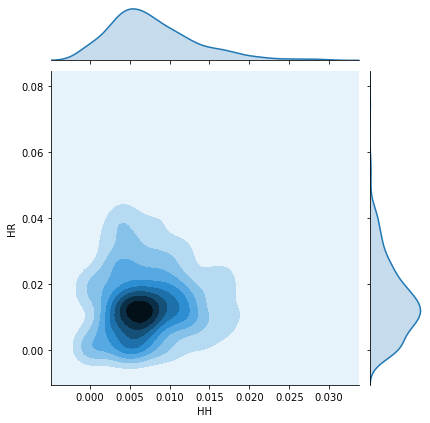

In [72]:
ax = sns.jointplot(p_align[p_align.conv == 1].lilla_conv_as_prime, p_align[p_align.conv == 2].lilla_conv_as_prime, kind='kde')
ax.set_axis_labels(xlabel='HH', ylabel='HR')
plt.show()

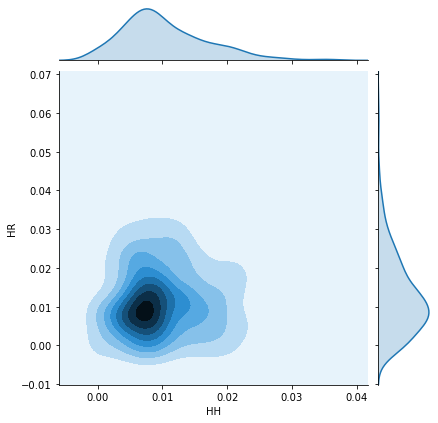

In [73]:
ax = sns.jointplot(p_align[p_align.conv == 1].lilla_part_as_prime, p_align[p_align.conv == 2].lilla_part_as_prime, kind='kde')
ax.set_axis_labels(xlabel='HH', ylabel='HR')
plt.show()

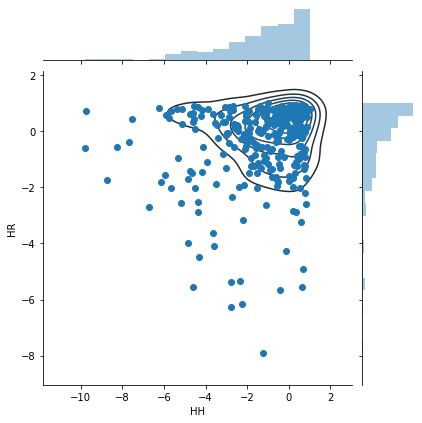

In [66]:
ax = sns.jointplot(p_align[p_align.conv == 1].scc_lex, p_align[p_align.conv == 2].scc_lex).plot_joint(sns.kdeplot, zorder=0, n_levels=10)
ax.set_axis_labels(xlabel='HH', ylabel='HR')
plt.show()

In [74]:
ordered_columns=['locutor', 'block', 'conv', 'it', 'Trial', 'prime']
removed_columns=['data', 'extract_text']
other_columns=sorted(list(set(p_align.columns) - set(ordered_columns) - set(removed_columns)))

p_align[ordered_columns + other_columns].to_excel('extracted_data_alignment_1.xlsx', index=False, header=True)